August: Calculating the V transport across the sections on the shelf break plane.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/transport_fluxes/')
import functions_transport_V
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

from salishsea_tools.nc_tools import scDataset

# $Q_j = v \times e1v \times e3v = v \times A_j$

In [2]:
import importlib
importlib.reload(functions_transport_V)

<module 'functions_transport_V' from '/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/transport_fluxes/functions_transport_V.py'>

In [3]:
def get_variables_fluxes(dirname, filepattern, ind_plane, vmask):
    files = general_functions.get_files(dirname, filepattern, 'grid_V')
    x, y =  slice(1,-1,None), int(ind_plane)
    with scDataset(files) as ds:
        vomecrty0 = ds.variables['vomecrty'][:, :, y, x]
    vmask0 = vmask[:, y, :]
    vmask = np.tile(vmask0, (vomecrty0.shape[0],1, 1))  
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    return vomecrty

# ------------------------------------------------------------------------------------------------

def calculate_flux_V(time_ind, velocity_plane, area_plane):
    '''Calculates flux at all cells at one time.
    velocity_plane (t, z, x)
    area_plane(z, x)
    '''
    Q_plane = velocity_plane[time_ind, :, :] * area_plane
    return Q_plane

# ------------------------------------------------------------------------------------------------

def calculate_flux_V_evolution(velocity_plane, area_plane):
    '''Calculates flux at all cells at all times.
    velocity_plane (t, z, x)
    area_plane(z, x)
    '''
    Q_plane_all = np.zeros_like(velocity_plane)
    for time_ind in range(Q_plane_all.shape[0]):
        Q_plane_all[time_ind, :, :] = calculate_flux_V(time_ind, velocity_plane, area_plane)
    return Q_plane_all

In [4]:
dirname = '/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'
filename = '1_mesh_mask.nc'

gdepv, vmask, mbathy, e1v, e3v_0 = functions_transport_V.get_variables_planes(dirname, filename)

In [5]:
ind_plane, ind_shelf, ind_bottom, ind_axis, ind_rimW, ind_rimE, ind_half, ind_shfW, ind_shfE,\
depth_shelf, depth_bottom, depth_half, area_j = functions_transport_V.get_indices_V(gdepv, vmask, mbathy, e1v, e3v_0)

ind_plane 178
ind_shelf 10
depth_shelf 91.875
ind_bottom 60
depth_bottom 534.672
ind_axis 110
ind_rimW 48
ind_rimE 172
ind_half 25
depth_half 223.125
ind_shfW 5
ind_shfE 215


In [6]:
filepattern = "1_MCKNZ_1h_20170101_20170120_*"
vomecrty = get_variables_fluxes(dirname, filepattern, ind_plane, vmask)

In [7]:
Q_j_all = calculate_flux_V_evolution(vomecrty, area_j)

In [8]:
vomecrty.shape, area_j.shape, Q_j_all.shape

((480, 80, 242), (80, 242), (480, 80, 242))

In [9]:
Q_j_shfW, Q_j_rimW, Q_j_rimE, Q_j_shfE, Q_j_topW, Q_j_topE, Q_j_botW, Q_j_botE = functions_transport_V.extract_sections(
    Q_j_all, ind_shelf, ind_bottom, ind_axis, ind_rimW, ind_rimE, ind_half, ind_shfW, ind_shfE)

In [10]:
Q_j_shfW.shape, Q_j_botE.shape

((480, 10, 43), (480, 34, 62))

In [11]:
axis = (1,2)

tot_Q_j_shfW, tot_Q_j_rimW, tot_Q_j_rimE, tot_Q_j_shfE, tot_Q_j_topW, tot_Q_j_topE, tot_Q_j_botW, tot_Q_j_botE = functions_transport_V.total_sections(
    axis, Q_j_shfW, Q_j_rimW, Q_j_rimE, Q_j_shfE, Q_j_topW, Q_j_topE, Q_j_botW, Q_j_botE)

In [12]:
tot_Q_j_shfW.shape, tot_Q_j_botE.shape

((480,), (480,))

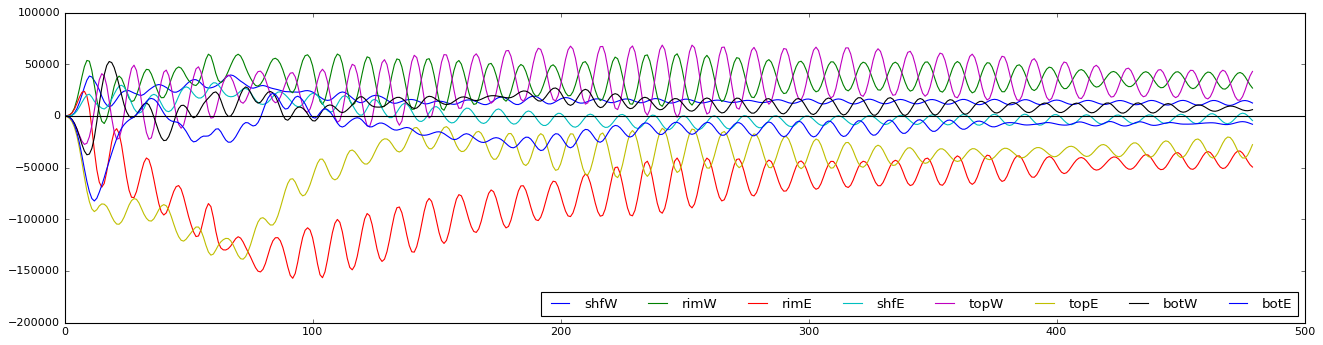

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
fluxes = [tot_Q_j_shfW, tot_Q_j_rimW, tot_Q_j_rimE, tot_Q_j_shfE, tot_Q_j_topW, tot_Q_j_topE, tot_Q_j_botW, tot_Q_j_botE]
labels = ['shfW', 'rimW', 'rimE', 'shfE', 'topW', 'topE', 'botW', 'botE']

for flux, label in zip(fluxes, labels):
    ax.plot(flux, label=label)
ax.legend(ncol = 8, loc=4)
ax.axhline(0, c='k')